In [1]:
import sys
sys.path.append('../../../self_learning_with_venn_abers_predictors/')

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.isotonic import IsotonicRegression
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.autograd import Variable
from collections import OrderedDict
import tensorflow as tf

from python_code.neural_net import MyDataset, Simple_Neural_Net, Simple_Neural_Net2
from python_code.self_learning import venn_abers_pytorch
from python_code.utils import plot_decision_boundary
from VennABERSToccaceli import ScoresToMultiProbs

2023-01-27 18:39:44.398888: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv("../../data/SynthCross_n1000_p2.csv")
df["z"] = df["z"].apply(lambda x: 1 if x=="A" else 0)

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(df[["X1", "X2"]], df["z"], train_size=0.8)
X_train, X_calib, Y_train, Y_calib = train_test_split(X_train, Y_train, train_size=0.975)
trainset = pd.DataFrame(X_train, columns=["X1", "X2"])
trainset["z"] = Y_train
trainset.iloc[80:, trainset.columns.get_loc("z")] = np.NaN 
known_train = trainset.iloc[0:80]
unknow_train = trainset.iloc[80:]
known_train.shape, unknow_train.shape, X_calib.shape, X_test.shape

((80, 3), (700, 3), (20, 2), (200, 2))

# Self learning strategy 1

In [4]:
class SelfLearning():
    def __init__(
        self,
        known_x_train,
        known_y_train,
        unknown_x_train,
        model_convergence_epochs 
    ):
        self.model_convergence_epochs = model_convergence_epochs
        self.model = Simple_Neural_Net(clipping_value=0.000001, n_units=1)
        self.known_x_train = known_x_train
        self.known_y_train = known_y_train
        self.unknown_x_train = unknown_x_train
        
        self.model.fit(self.known_x_train, self.known_y_train, epochs=self.model_convergence_epochs, learning_rate=0.1)
        self.accuracies = []
    
    def learning(self, validation_x, validation_y, batch_adding=5):
        while len(self.unknown_x_train) >= batch_adding:
            self.unknown_x_train["y"] = self.model.predict_probas(self.unknown_x_train.to_numpy()).detach().numpy()
            self.unknown_x_train.sort_values("y", ascending=False, inplace=True)
            self.unknown_x_train["y"] = self.unknown_x_train["y"].apply(lambda x: 1 if x>0.5 else 0)
            self.known_x_train = pd.concat(
                [
                    self.known_x_train,
                    self.unknown_x_train.iloc[0:batch_adding][["X1", "X2"]],
                    self.unknown_x_train.iloc[-batch_adding:][["X1", "X2"]]
                ]
            )
            self.known_y_train = pd.concat(
                [
                    self.known_y_train,
                    self.unknown_x_train.iloc[0:batch_adding]["y"],
                    self.unknown_x_train.iloc[-batch_adding:]["y"]
                ]
            )
            self.unknown_x_train = self.unknown_x_train.iloc[batch_adding:-batch_adding][["X1", "X2"]]
            predictions = self.model.predict_probas(validation_x.to_numpy()).reshape(-1).detach().numpy().round()
            self.accuracies.append(accuracy_score(validation_y, predictions))
            self.model.fit(self.known_x_train, self.known_y_train, epochs=self.model_convergence_epochs, learning_rate=0.1, verbose=False)

Epoch 1/10
8/8 [==============================] - 0s 3ms/step - loss: 0.6249 - accuracy: 0.6250
Epoch 2/10
8/8 [==============================] - 0s 2ms/step - loss: 0.6176 - accuracy: 0.6375
Epoch 3/10
8/8 [==============================] - 0s 3ms/step - loss: 0.6135 - accuracy: 0.6500
Epoch 4/10
8/8 [==============================] - 0s 2ms/step - loss: 0.6110 - accuracy: 0.6500
Epoch 5/10
8/8 [==============================] - 0s 3ms/step - loss: 0.6090 - accuracy: 0.6500
Epoch 6/10
8/8 [==============================] - 0s 3ms/step - loss: 0.6071 - accuracy: 0.6500
Epoch 7/10
8/8 [==============================] - 0s 2ms/step - loss: 0.6056 - accuracy: 0.6500
Epoch 8/10
8/8 [==============================] - 0s 5ms/step - loss: 0.6039 - accuracy: 0.6500
Epoch 9/10
8/8 [==============================] - 0s 4ms/step - loss: 0.6019 - accuracy: 0.6500
Epoch 10/10
8/8 [==============================] - 0s 3ms/step - loss: 0.5999 - accuracy: 0.6500



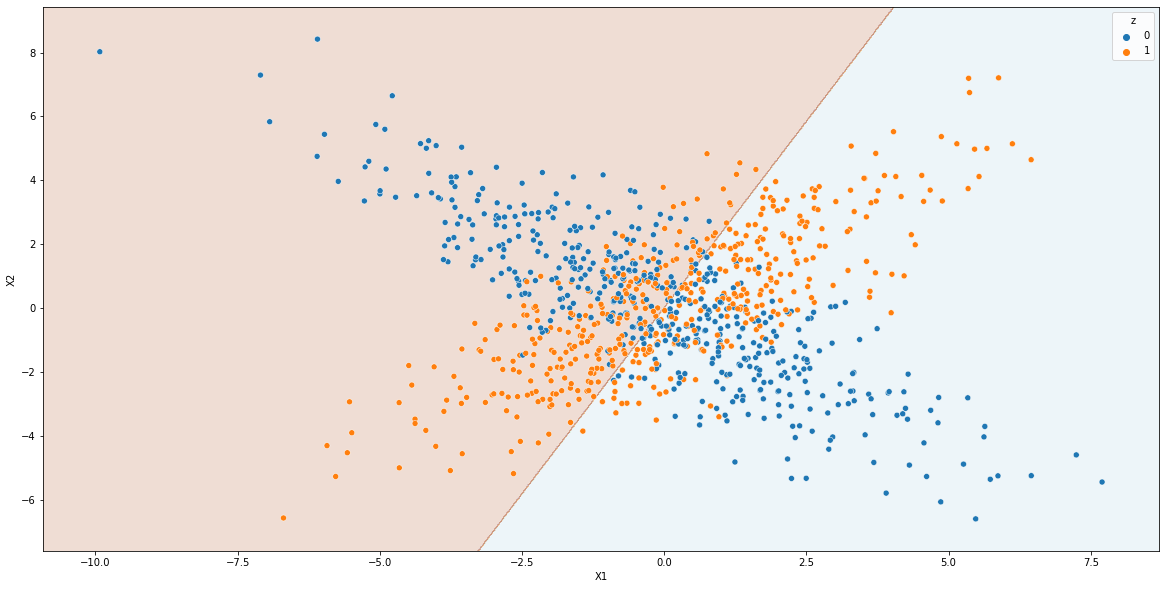

In [5]:
test = SelfLearning(
    known_x_train=known_train[["X1", "X2"]],
    known_y_train=known_train["z"],
    unknown_x_train=unknow_train[["X1", "X2"]],
    model_convergence_epochs=10
)
test.learning(validation_x=X_test, validation_y=Y_test)
fig, ax = plot_decision_boundary(dataset=df[["X1", "X2"]], labels=np.array([0, 1]), model=test.model)
sns.scatterplot(data=df, x="X1", y="X2", hue="z", ax=ax)
plt.show()

In [6]:
accuracy_score(test.model.predict_probas(X_test.to_numpy()).reshape(-1).detach().numpy().round(), Y_test)

0.485

# Self learning strategy 2

In [7]:
class SelfLearningWithSoft():
    def __init__(
        self,
        known_x_train,
        known_y_train,
        unknown_x_train,
        model_convergence_epochs 
    ):
        self.model_convergence_epochs = model_convergence_epochs
        self.model = Simple_Neural_Net(clipping_value=0.000001, n_units=1)
        self.known_x_train = known_x_train
        self.known_y_train = known_y_train
        self.unknown_x_train = unknown_x_train
        self.length_known = len(self.known_y_train)
        
        self.model.fit(self.known_x_train, self.known_y_train, epochs=self.model_convergence_epochs, learning_rate=0.001)
        self.accuracies = []
    
    def learning(self, validation_x, validation_y, n_epochs=10):
        for epochs in range(n_epochs):
            # print(self.known_y_train)
            # print()
            self.known_y_train = self.known_y_train.apply(lambda x: x-0.001 if x==1 else x+0.001 if x==0 else x)
            # print(self.known_y_train)
            self.unknown_x_train["y"] = self.model.predict_probas(self.unknown_x_train.to_numpy()).detach().numpy()
            # import pdb; pdb.set_trace()
            self.known_x_train = pd.concat(
                [
                    self.known_x_train,
                    self.unknown_x_train[["X1", "X2"]],
                ]
            ).drop_duplicates()
            if epochs == 0:
                self.known_y_train = pd.concat(
                    [
                        self.known_y_train,
                        self.unknown_x_train["y"],
                    ]
                )
            else:
                self.known_y_train[self.length_known:] = self.unknown_x_train["y"]
            self.unknown_x_train = self.unknown_x_train[["X1", "X2"]]
            predictions = self.model.predict_probas(validation_x.to_numpy()).reshape(-1).detach().numpy().round()
            self.accuracies.append(accuracy_score(validation_y, predictions))
            print(f"Accuracy epochs {epochs}: {accuracy_score(validation_y, predictions)}")
            self.model.fit(
                self.known_x_train, self.known_y_train, epochs=self.model_convergence_epochs, learning_rate=0.1, verbose=False, soft=True
            )

Epoch 1/10
8/8 [==============================] - 0s 2ms/step - loss: 0.7713 - accuracy: 0.5125
Epoch 2/10
8/8 [==============================] - 0s 2ms/step - loss: 0.7711 - accuracy: 0.5125
Epoch 3/10
8/8 [==============================] - 0s 3ms/step - loss: 0.7708 - accuracy: 0.5125
Epoch 4/10
8/8 [==============================] - 0s 2ms/step - loss: 0.7705 - accuracy: 0.5125
Epoch 5/10
8/8 [==============================] - 0s 2ms/step - loss: 0.7702 - accuracy: 0.5125
Epoch 6/10
8/8 [==============================] - 0s 3ms/step - loss: 0.7700 - accuracy: 0.5125
Epoch 7/10
8/8 [==============================] - 0s 3ms/step - loss: 0.7697 - accuracy: 0.5125
Epoch 8/10
8/8 [==============================] - 0s 3ms/step - loss: 0.7694 - accuracy: 0.5125
Epoch 9/10
8/8 [==============================] - 0s 3ms/step - loss: 0.7692 - accuracy: 0.5125
Epoch 10/10
8/8 [==============================] - 0s 3ms/step - loss: 0.7689 - accuracy: 0.5125
Accuracy epochs 0: 0.5
Accuracy epochs 

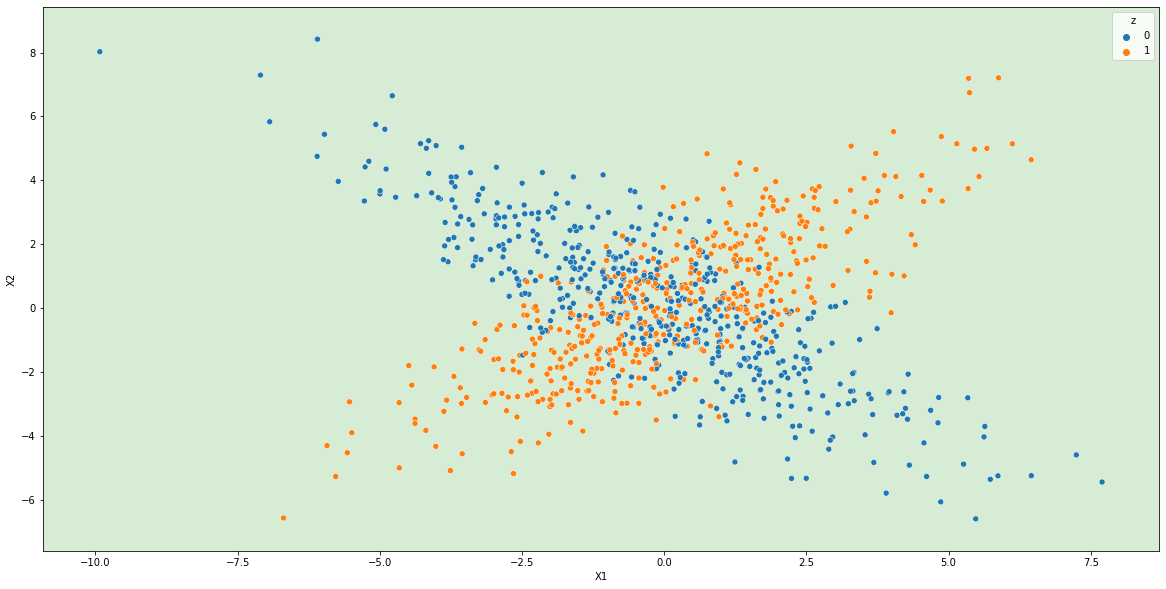

In [8]:
test = SelfLearningWithSoft(
    known_x_train=known_train[["X1", "X2"]],
    known_y_train=known_train["z"],
    unknown_x_train=unknow_train[["X1", "X2"]],
    model_convergence_epochs=10
)
test.learning(validation_x=X_test, validation_y=Y_test, n_epochs=10)
fig, ax = plot_decision_boundary(dataset=df[["X1", "X2"]], labels=np.array([0, 1]), model=test.model)
sns.scatterplot(data=df, x="X1", y="X2", hue="z", ax=ax)
plt.show()

In [9]:
accuracy_score(test.model.predict_probas(X_test.to_numpy()).reshape(-1).detach().numpy().round(), Y_test)

0.5

# Self learning strategy 3

In [10]:
class SelfLearningUsingVennAbers():
    def __init__(
        self,
        known_x_train,
        known_y_train,
        unknown_x_train,
        calib_x_train, 
        calib_y_train,
        model_convergence_epochs
    ):
        self.model_convergence_epochs = model_convergence_epochs
        self.model = Simple_Neural_Net2(clipping_value=0.1, n_units=1)
        self.known_x_train = known_x_train
        self.known_y_train = known_y_train
        self.unknown_x_train = unknown_x_train
        self.calib_x_train = calib_x_train
        self.calib_y_train = calib_y_train
        self.length_known = len(self.known_y_train)
        
        self.model.fit(self.known_x_train, self.known_y_train, epochs=self.model_convergence_epochs, learning_rate=0.2)
        self.accuracies = []
        fig, ax = plot_decision_boundary(dataset=df[["X1", "X2"]], labels=np.array([0, 1]), model=self.model)
        sns.scatterplot(data=df, x="X1", y="X2", hue="z", ax=ax)
        plt.show()
    
    def learning(self, validation_x, validation_y, n_epochs=10):
        self.known_y_train = self.known_y_train.apply(
            lambda x: np.stack(
                [x+0.001, x+0.001] if x == 0 else [x-0.001, x-0.001] if x ==1 else x,
                axis=-1
        ).astype(np.float32))
        for epochs in range(n_epochs):
            self.unknown_x_train["interval"] =  self.unknown_x_train.apply(
                lambda x: venn_abers_pytorch(
                    self.model,
                    torch.from_numpy(self.calib_x_train[["X1", "X2"]].values.astype(np.float32)),
                    torch.from_numpy(x[["X1", "X2"]].values.reshape(1, -1).astype(np.float32)),
                    self.calib_y_train)
                ,
                axis=1
            )
            self.known_x_train = pd.concat(
                [
                    self.known_x_train,
                    self.unknown_x_train[["X1", "X2"]],
                ]
            ).drop_duplicates()
            if epochs == 0:
                self.known_y_train = pd.concat(
                    [
                        self.known_y_train,
                        self.unknown_x_train["interval"],
                    ]
                )
            else:
                self.known_y_train[self.length_known:] = self.unknown_x_train["interval"]
            
            self.unknown_x_train = self.unknown_x_train[["X1", "X2"]]
            predictions = self.model.predict_probas(validation_x.to_numpy()).reshape(-1).detach().numpy().round()
            self.accuracies.append(accuracy_score(validation_y, predictions))
            if (epochs+1) % 5 == 0 or epochs==0:
                print(f"Accuracy epochs {epochs+1}: {accuracy_score(validation_y, predictions)}")
                fig, ax = plot_decision_boundary(dataset=df[["X1", "X2"]], labels=np.array([0, 1]), model=self.model)
                sns.scatterplot(data=df, x="X1", y="X2", hue="z", ax=ax)
                plt.show()
            self.model.fit(
                self.known_x_train,
                self.known_y_train,
                epochs=self.model_convergence_epochs,
                learning_rate=0.2,
                verbose=False,
                credal=True
            )
            
    
    def predict_probas(self, x_test):
        probs = self.model.predict_probas(x_test, from_numpy=True, as_numpy=True)
        return probs
    
    def predict_probas_interval(self, x_test):
        returns = x_test.copy()
        returns["interval"] = returns.apply(
                lambda x: venn_abers_pytorch(
                    self.model,
                    torch.from_numpy(self.calib_x_train[["X1", "X2"]].values.astype(np.float32)),
                    torch.from_numpy(x[["X1", "X2"]].values.reshape(1, -1).astype(np.float32)),
                    self.calib_y_train)
                ,
                axis=1
            )
        return returns

Epoch 1/10
8/8 [==============================] - 0s 3ms/step - loss: 0.7524 - accuracy: 0.5125
Epoch 2/10
8/8 [==============================] - 0s 5ms/step - loss: 0.7019 - accuracy: 0.6125
Epoch 3/10
8/8 [==============================] - 0s 3ms/step - loss: 0.6886 - accuracy: 0.5625
Epoch 4/10
8/8 [==============================] - 0s 4ms/step - loss: 0.6819 - accuracy: 0.5375
Epoch 5/10
8/8 [==============================] - 0s 4ms/step - loss: 0.6761 - accuracy: 0.5625
Epoch 6/10
8/8 [==============================] - 0s 4ms/step - loss: 0.6722 - accuracy: 0.5750
Epoch 7/10
8/8 [==============================] - 0s 3ms/step - loss: 0.6695 - accuracy: 0.5750
Epoch 8/10
8/8 [==============================] - 0s 2ms/step - loss: 0.6671 - accuracy: 0.5750
Epoch 9/10
8/8 [==============================] - 0s 2ms/step - loss: 0.6664 - accuracy: 0.5875
Epoch 10/10
8/8 [==============================] - 0s 3ms/step - loss: 0.6624 - accuracy: 0.6000



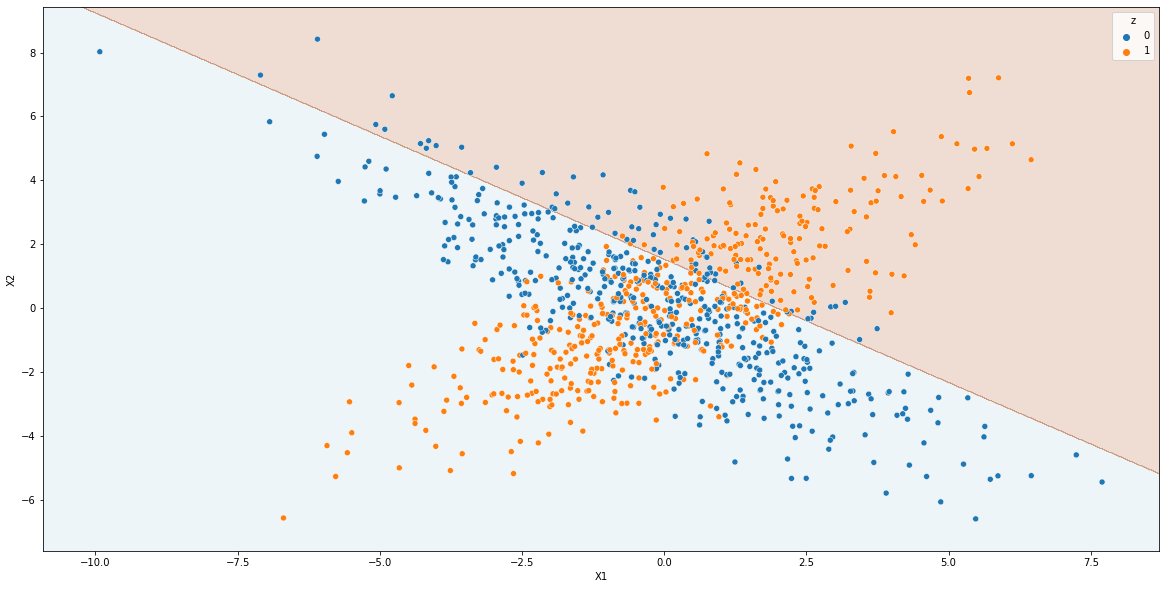

In [11]:
test = SelfLearningUsingVennAbers(
    known_x_train=known_train[["X1", "X2"]],
    known_y_train=known_train["z"],
    unknown_x_train=unknow_train[["X1", "X2"]],
    calib_x_train=X_calib[["X1", "X2"]],
    calib_y_train=Y_calib,
    model_convergence_epochs=10
)

Accuracy epochs 1: 0.62



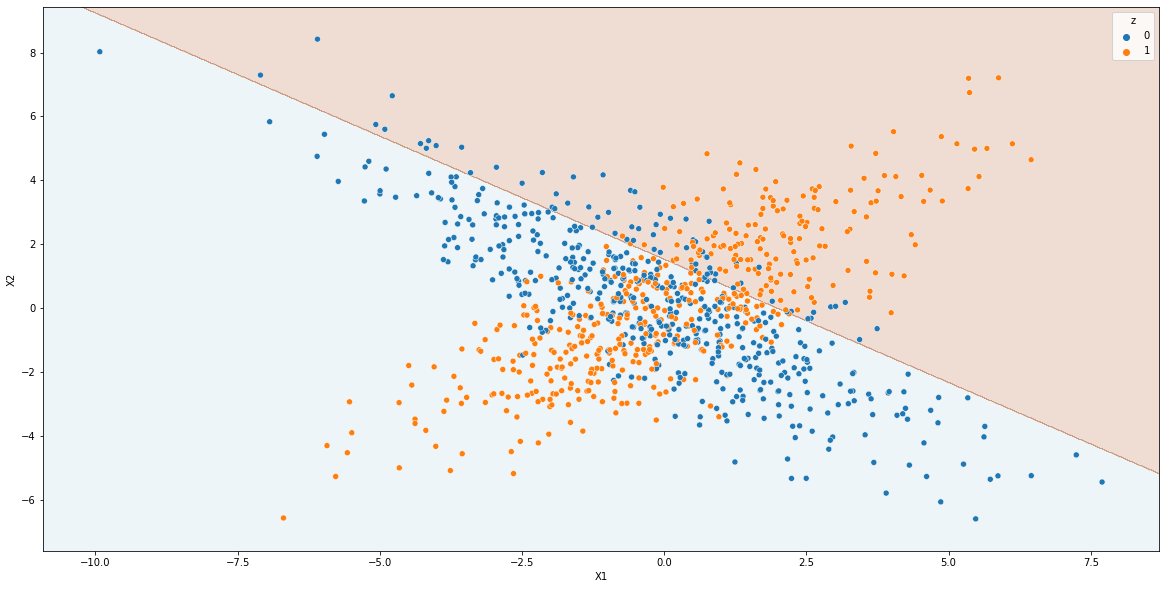

Accuracy epochs 5: 0.625



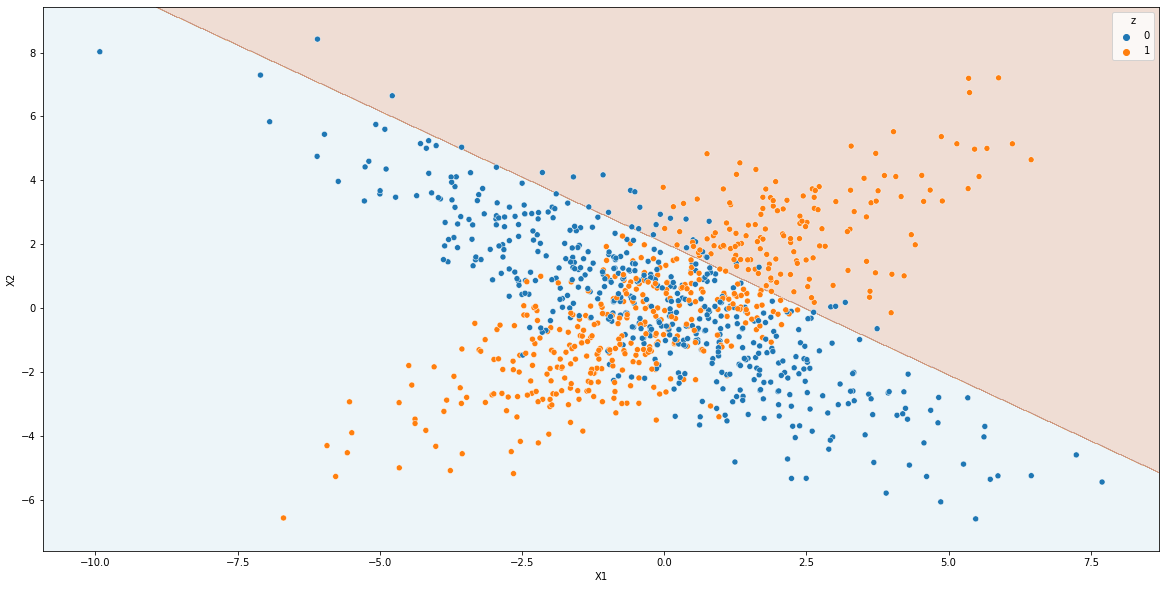

Accuracy epochs 10: 0.615



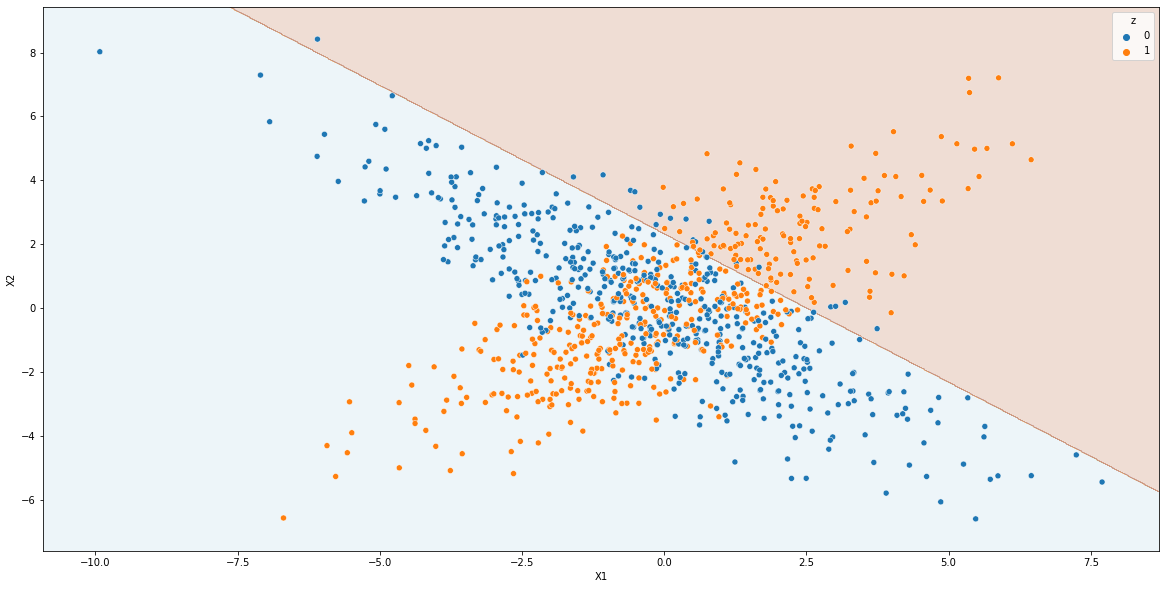

In [12]:
test.learning(validation_x=X_test, validation_y=Y_test, n_epochs=10)

In [13]:
accuracy_score(test.model.predict_probas(X_test.to_numpy()).reshape(-1).detach().numpy().round(), Y_test)

0.615

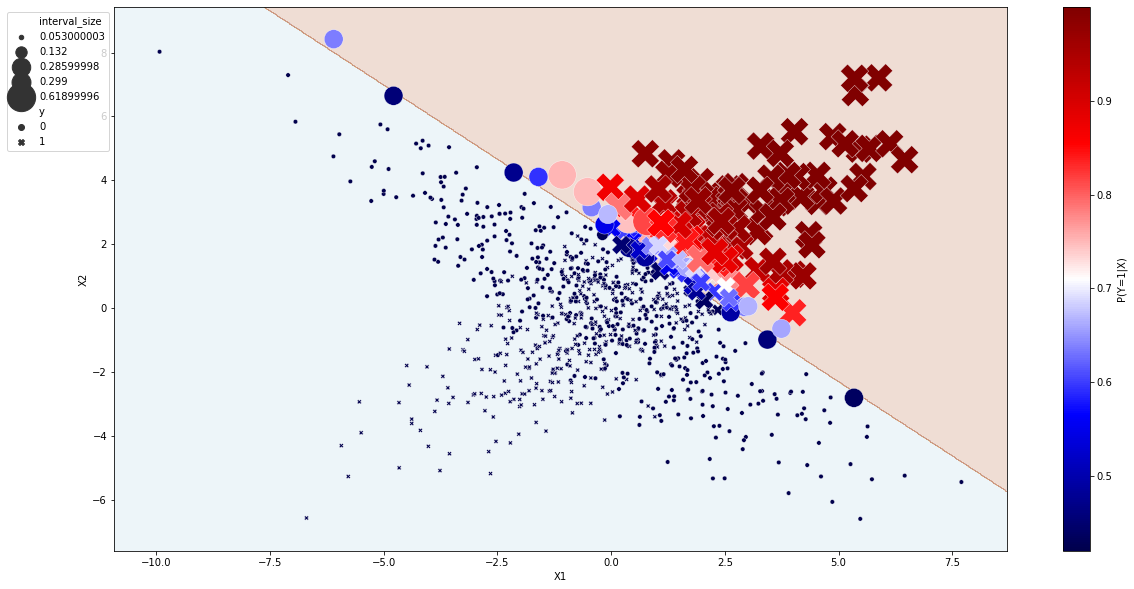

In [14]:
dff = pd.concat([df,pd.concat([X_calib, Y_calib], axis=1)]).drop_duplicates(keep=False)
new_df = test.predict_probas_interval(x_test=dff[["X1", "X2"]])
new_df["interval_size"] = new_df["interval"].apply(lambda x: x[1] - x[0])
new_df["predicted"] = test.model.predict_probas(new_df[["X1", "X2"]].to_numpy()).detach().numpy()
new_df["label_predicted"] = test.model.predict_probas(new_df[["X1", "X2"]].to_numpy()).detach().numpy().round()
new_df["y"] = dff["z"]
fig, ax = plot_decision_boundary(dataset=new_df, labels=np.array([0, 1]), model=test.model)
ax = sns.scatterplot(
    data=new_df,
    x="X1",
    y="X2",
    c=new_df["predicted"],
    ax=ax,
    size="interval_size",
    sizes=(20, 800),
    style="y",
    cmap = 'seismic'
)
norm = plt.Normalize(new_df['predicted'].min(), new_df['predicted'].max())
sm = plt.cm.ScalarMappable(cmap="seismic", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('P(Y=1|X)')
sns.move_legend(ax, "upper right", bbox_to_anchor=(0, 1))
plt.show()

In [15]:
new_df

,X1,X2,interval,interval_size,predicted,label_predicted,y
0,-1.749251,-2.193997,"[0.368, 0.421]",0.053,0.419793,0.0,1
1,1.386376,-2.767844,"[0.368, 0.421]",0.053,0.419793,0.0,0
2,-2.958871,2.788016,"[0.368, 0.421]",0.053,0.419793,0.0,0
3,2.237879,-5.339690,"[0.368, 0.421]",0.053,0.419793,0.0,0
4,-1.900489,0.934474,"[0.368, 0.421]",0.053,0.419793,0.0,0
...,...,...,...,...,...,...,...
995,-2.217138,2.789515,"[0.368, 0.421]",0.053,0.419793,0.0,0
996,-0.034534,0.628338,"[0.368, 0.421]",0.053,0.419793,0.0,0
997,-0.310389,0.263887,"[0.368, 0.421]",0.053,0.419793,0.0,0
998,1.353930,0.391433,"[0.368, 0.421]",0.053,0.419793,0.0,1
